In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.parsing as parsing

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Parsing 

Note that this chapter is heavily influenced by the structure and content of [Mike Collins' PCFG lecture](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/pcfgs.pdf). 

In many NLP applications it is useful to understand the syntactic structure of a sentence: where are the verbs, what are the subject and object of the verbs, which phrases form coherent sub-structures of the sentence? Understanding this enables the machine to more effectively translate from Japanese to English, or to understand the query ["who is the president of the united state"](https://www.google.co.uk/search?q=who+is+the+president+of+the+united+state&oq=who+is+the+president+of+the+united+state&aqs=chrome..69i57j0l5.252j0j4&sourceid=chrome&es_sm=119&ie=UTF-8) and execute it against a database. 

In linguistics these questions are asked in the field of **syntax**, from the Greek syntaxis (arrangement). There are three core concepts:

* **Constituency**: groups of words act as single units.
* **Grammatical Relations**: object, subject, direct object etc. 
* **Subcategorization**: restrictions on the type of phrases that go with certain words.

## Context Free Grammars
A common approach to capture constituency, grammatical relations and subcategorization is based on [Context Free Grammars](https://www.cs.rochester.edu/~nelson/courses/csc_173/grammars/cfg.html) (CFGs). On a high level, these grammars assume that legal sentences can be derived by repeatedly and _independently_ expanding abstract symbols (such as "NounPhrase" or "Adjective") into more concrete sequences of symbols (such as "Adjective Noun" or "green") until each symbol is a concrete word. 

More formally, a CFG is a 4-tuple \\(G=(N,\Sigma,R,S)\\) where

  * \\(N\\) is a set of _non-terminal symbols_.
  * \\(\Sigma\\) is a set of _terminal symbols_.
  * \\(R\\) is a finite set of _rules_ \\(X \rightarrow Y_1 Y_2\ldots Y_n\\) where \\(X \in N\\) and \\(Y_i \in N \cup \Sigma\\). 
  * \\(S \in N\\) is a _start symbol_. 

Before we show examples, let us define a Python data structure for CFGs.

In [566]:
class CFG:
    """
    A Python representation of a context free grammar.
    """
    def __init__(self, n, sigma, r, s):
        """
        Creates a new CFG.
        Args:
            n: the set of non-terminals
            sigma: the set of terminals
            r: the list of rules as pairs `(lhs, rhs)` where rhs is a list of right-hand side symbols of the rule.
            s: the starting symbol
        """
        self.n = n
        self.sigma = sigma
        self.r = [(lhs,tuple(rhs)) for lhs,rhs in r]
        self.s = s
    
    @classmethod
    def from_rules(cls, rules, s='S'):
        """
        Creates a CFG just from given rules. Symbols in the rules that appear on the left-hand sides
        are non-terminals, all other symbols are non-terminals.
        Args:
            rules: the list of rules to build the CFG from
            s: the start symbol.
        Returns:
            a CFG with induces terminal and non-terminals.
        """
        non_terminals = {rule[0] for rule in rules}
        left_hand_sides = {node for rule in rules for node in rule[1]}
        terminals = {n for n in left_hand_sides if n not in non_terminals}
        return cls(non_terminals, terminals, rules, s)
    
    def _repr_html_(self):
        """
        Simple HTML representation of a CFG for easy rendering in notebook.
        Returns:
            an HTML string representing the CFG as table.
        """
        rules = ["<tr><td>{}</td><td>{}</td></tr>".format(rule[0]," ".join(rule[1])) for rule in self.r]
        return "<table>{}</table>".format("".join(rules))

Let us now create an example CFG.

In [567]:
cfg = CFG.from_rules([('S',    ['NP_p','VP_p']),('S',['NP_s','VP_s']), 
                      ('NP_p', ['Matko', 'raps']),
                      ('VP_p', ['are', 'ADJ']),
                      ('NP_s', ['Matko']),
                      ('VP_s', ['raps', 'in', 'StatNLP']),
                      ('ADJ',  ['silly'])
                     ])
cfg

S,NP_p VP_p
S,NP_s VP_s
NP_p,Matko raps
VP_p,are ADJ
NP_s,Matko
VP_s,raps in StatNLP
ADJ,silly


## (Left-most) Derivation
A left-most derivation given a CFG \\(G\\) is a sequence of strings \\(s_1 \ldots s_n\\) such that 

* \\(s_1 = S\\), that is, the first string consists only of the start symbol.
* \\(s_n \in \Sigma^*\\), that is, the last string consists of only terminals.
* Each \\(s_i\\) for \\(i > 1\\) is generated by replacing the left-most non-terminal \\(\alpha\\) with the right-hand side of any rule that has \\(\alpha\\) as left-hand side. 

Let us write some code that puts this definition into action and generates random derivations based on a grammar. 

In [570]:
import random
def generate_deriv(cfg, sentence, results = None):
    """
    Given a CFG and input sentence, generate a tuple of lists corresponding to a derivation as defined above.
    Args:
        cfg: a CFG
        sentence: list of tokens (strings)
        results: derivation built so far. If `None` is passed a singleton tuple with the 
                 sentence as element is used as initial derivation.
    Returns:
        a tuple representing the individual sentences in the derivation.
    """
    actual_result = (sentence,) if results is None else results
    non_terminals = ((t,i) for i, t in enumerate(sentence) if t in cfg.n)
    first_non_terminal, first_index = next(non_terminals, (None, -1))
    if first_non_terminal is not None:
        relevant_rules = [rule for rule in cfg.r if rule[0] == first_non_terminal]
        sampled_rule = random.choice(relevant_rules)
        new_sentence = sentence[:first_index] + list(sampled_rule[1]) + sentence[first_index+1:]
        return generate_deriv(cfg, new_sentence, actual_result + (new_sentence,))
    else:
        return actual_result

Let us generate an example derivation.

In [572]:
generate_deriv(cfg, [cfg.s])

(['S'],
 ['NP_p', 'VP_p'],
 ['Matko', 'raps', 'VP_p'],
 ['Matko', 'raps', 'are', 'ADJ'],
 ['Matko', 'raps', 'are', 'silly'])

## Parse Trees
Derivations can be compactly present as trees where each non-leaf node corresponds to an expanded left-hand-side and its children to the rules' right hand side. We will represent trees simply by using string objects for terminal nodes, and `(label,children)` tuples for non-terminals where `label` is the string non-terminal label, and `children` is a list of child trees.

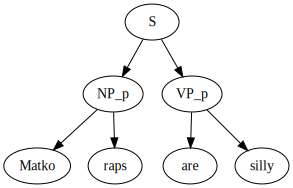

In [573]:
tree = ('S', [('NP_p',['Matko','raps']), ('VP_p',['are','silly'])])
parsing.render_tree(tree)

In the same way we could generate derivations before, we can now generate parse trees from a CFG.

In [574]:
def generate_tree(cfg, rhs):
    if rhs in cfg.sigma:
        return rhs
    else:
        relevant_rules = [rule for rule in cfg.r if rule[0] == rhs]
        sampled_rule = random.choice(relevant_rules)
        children = [generate_tree(cfg, child) for child in sampled_rule[1]]
        return (rhs, children)

Now let us generate a tree, starting from a non-terminal in the CFG.

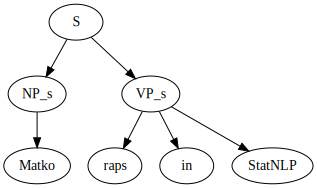

In [575]:
render_tree(generate_tree(cfg,'S'))        

## Finding Parse Trees
As you can see, parse trees uncover how a sentence is structured with respect to a grammar. In fact, they give us insights about both constituency and grammatical relations: In the above case the subtrees headed by "NP" nodes represent noun phrase constituents; likewise, the "NP" and "VP" subtrees under "S" represent the subject and object of a sentence. It is interesting to generate trees and hence sentences given a starting symbol. However, in practice it is often more useful to find a parse tree given a sentence, if existent. This process is generally referred to as parsing. 

There are a couple of approaches to find a legal parse tree given a sentence and grammar:

* **Top-Down**: Start with the start symbol and generate trees; backtrack if they do not match observed sentence.
* **Bottom-Up**: Start with the sentence, and find rules that generate parts of it; backtrack if no start symbol can be induced.
* **Dynamic Programming**: Explore several trees in parallel and re-use computations.

### Bottom-Up Parsing with Backtracking
A bottom-up parser with backtracking maintains a state consisting of a stack of processed trees, and buffer of remaining words, and a history of previous states we can backtrack to if we cannot make more progress. Roughly speaking, the algorithm proceeds by iteratively reducing the stack via rules to new trees, moving forward in the sentence, and backtracking to previous states when we reach the end of the sentence but cannot create a single tree. 

More formally, the algorithm operates a machine with a state $S=(b,t,r)$ where $b$ is a buffer of remaining words to process, $t$ a stack of trees build so far, and $r$ a list of rules that remain to be checked for whether they can applied to the top elements of $t$. The algorithm also maintains a history $h$ of previously visited states. 

* **Input**: sentence $s$, Rules $R$.
* **Initialisation**:
  * $b \leftarrow s$
  * $r \leftarrow R$
  * $t \leftarrow ()$
  * $h \leftarrow ()$
* **while** $|b| > 0$ or $|r| > 0$ or both $|s| > 1$ and $|h| > 0$
  * **if** $|r| > 0$ reduce
  * **if** $|b| > 0$ shift
  * **else if** $|s| > 1$ back-track
  
The core operations within the algorithm are:

* **reduce**:
  * **while** $|r|>0$:
    * Let the first rule in $r$ be $r_1 = \alpha \leftarrow \beta_1 \ldots \beta_n$
    * check whether $\beta_1 \ldots \beta_n$ is equal to the labels of the top of the stack $t_1 \ldots t_n$
    * If so, remember current state $S$ in history $h$, set $r \leftarrow R$, pop $n$ elements from the tree stack $t$ and push the tree $(alpha, t_1 \ldots t_n)$ onto $t$.
    * Otherwise: remove $r_1$ from the list of rules $r$.
* **shift**:
  * append the first element $b_1$ of the buffer $b$ to $t$ and remove $b_1$ from $b$.
  * Initialise rules again by setting $r \leftarrow R$
* **back-track**:
  * set $G=h_\text{last}$ where $h_\text{last}$ is the last element from the history $h$ 
  * Remove $h_\text{last}$ from $h$. 
  * Remove the first rule $r_1$ from the list of rules $r$.

In Python code the parsing algorithm can be formulated as follows. Notice that because we are making in-place changes to the current state object, when recording states for later visualisation and for backtracking we need to perform deep-copy operations. In an actual parser this would soon become a major bottleneck, and in practice one would need to find more efficient ways to keep track of past states. 

In [578]:
class State:
    def __init__(self, stack, buffer, rules):
        self.stack = stack
        self.buffer = buffer
        self.rules = rules
    
import copy
def bottom_up_parse(cfg, sentence):
    history = []
    state = State([], sentence, cfg.r)
    transitions = [(copy.deepcopy(state),'Init')]
    
    def reduce():
        while len(state.rules) > 0:
            lhs, rhs = state.rules[0]
            top = state.stack[-len(rhs):]
            top_labels = [parsing.get_label(node) for node in top]
            if tuple(top_labels) == rhs:
                history.append(copy.deepcopy(state))
                state.stack = state.stack[:-len(rhs)] + [(lhs, top)]
                state.rules = cfg.r
                transitions.append((copy.deepcopy(state),'Reduce'))
            else:
                state.rules = state.rules[1:]
    
    def shift():
        state.stack = state.stack + [state.buffer[0]] 
        state.buffer = state.buffer[1:]
        state.rules = cfg.r
        transitions.append((copy.deepcopy(state),'Shift'))
    
    def backtrack():
        nonlocal state
        state = history[-1]
        state.rules = state.rules[1:]
        transitions.append((copy.deepcopy(state),'Backtrack'))
        del history[-1]

    while len(state.buffer) > 0 or (len(state.stack) > 1 and len(history) > 0) or len(state.rules) > 0:
        if len(state.rules) > 0:
            reduce()
        if len(state.buffer) > 0:
            shift()
        elif len(state.stack) > 1:
            backtrack()
    return transitions

Let us parse a simple sentence using this algorithm.

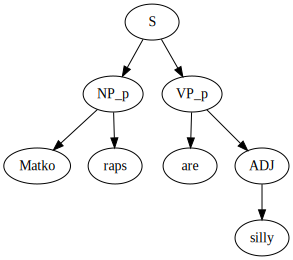

In [579]:
sentence = ['Matko', 'raps', 'are', 'silly']
transitions = bottom_up_parse(cfg, sentence)
parsing.render_forest(transitions[-1][0].stack)

We can also inspect the individual transitions performed during parsing.

In [580]:
parsing.render_transitions(transitions)

Matko raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",Init
raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko",Shift
raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0",Reduce
are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps",Shift
silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps <!-- 3 --> 3 are",Shift
,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps <!-- 3 --> 3 are <!-- 4 --> 4 silly",Shift
,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps <!-- 3 --> 3 are <!-- 4 --> 4 silly <!-- 5 --> 5 ADJ <!-- 5->4 --> 5->4",Reduce
,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps <!-- 3 --> 3 are <!-- 4 --> 4 silly <!-- 5 --> 5 ADJ <!-- 5->4 --> 5->4 <!-- 6 --> 6 VP_p <!-- 6->3 --> 6->3 <!-- 6->5 --> 6->5",Reduce
,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps <!-- 3 --> 3 are <!-- 4 --> 4 silly <!-- 5 --> 5 ADJ <!-- 5->4 --> 5->4",Backtrack
,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko <!-- 1 --> 1 NP_s <!-- 1->0 --> 1->0 <!-- 2 --> 2 raps <!-- 3 --> 3 are <!-- 4 --> 4 silly",Backtrack
raps are silly,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 Matko",Backtrack


## Dynamic Programming for Parsing
A problem with the bottom-up parser is the fact that, after back-tracking, it may redo many steps it had already before (can you find examples of this behaviour in the transitions above?). This suggests to remember steps and re-use then when needed. This is the general idea behind _dynamic programming_: caching and reusing computation whenever possible. 

### Chomsky Normal Form
In the case of CFG parsing there exists a very effective dynamic program, the so-called Cocke–Younger–Kasami (CYK) algorithm. However, before we can apply this algorithm we need to _normalize_ the grammar. In particular, we need to make sure that each rule has one of the following forms:

* \\(\alpha \rightarrow \beta \gamma\\) where \\(\beta,\gamma \in N \setminus \\{ S  \\} \\). 
* \\(\alpha \rightarrow t\\) where \\(t \in \Sigma\\).

In words: each rule is either binary and expands into two non-terminal non-Start symbols, or unary and expands into a word. This form is called _Chomsky Normal Form_ (CNF). 

Fortunately we can convert every CFG into an equivalent CFG in CNF, in the sense that any derivation or parse of sentence in one grammar can be loss-lessly converted to a derivation in the other grammar. This can be achieved through a few simple transformations. Here the rules on the left-hand side of the transformation arrow $\Rightarrow$ will be replaced by the ones on the left-hand side:  

* $\alpha \rightarrow \beta \gamma \delta \Rightarrow \alpha \rightarrow \beta\alpha', \alpha' \rightarrow \gamma \delta$
* $\alpha \rightarrow \beta t \Rightarrow \alpha \rightarrow \beta \alpha', \alpha' \rightarrow t$ where $t \in \Sigma$
* $\alpha \rightarrow \beta, \beta \rightarrow \gamma \Rightarrow \alpha \rightarrow \gamma, \beta \rightarrow \gamma$ 

We present this conversion in Python below, but omitted the third transformation which is not relevant for the  grammar we are using here (Exercise: add this case).

In [583]:
def to_cnf(cfg):
    # go through all rules, check if rule 1) or 2) can be applied, create new rules
    new_non_terminals = []
    
    def fresh_non_terminal(prefix):
        new_non_terminal = prefix + "_" + str(len(new_non_terminals))
        new_non_terminals.append(new_non_terminal)
        return new_non_terminal
    
    def transform_rule(rule):
        lhs, rhs = rule
        if len(rhs) > 2:
            # lhs -> r1 r2 ... rn
            new_lhs = fresh_non_terminal(lhs)
            new_rule_1 = (lhs, rhs[:1] + (new_lhs,))
            new_rule_2 = (new_lhs, rhs[1:])
            return transform_rule(new_rule_1) + transform_rule(new_rule_2)
        elif len(rhs) == 2 and any((n in cfg.sigma for n in rhs)):
            new_rules = []
            new_rhs = []
            for n in rhs:
                if n in cfg.sigma:
                    new_lhs = fresh_non_terminal(lhs)
                    new_rule = (new_lhs,[n])
                    new_rules.append(new_rule)
                    new_rhs.append(new_lhs)
                else:
                    new_rhs.append(n)
            new_rules.append((lhs,new_rhs))
            return sum([transform_rule(r) for r in new_rules], [])
        else:
            return [rule]
    
    result = []
    for rule in cfg.r:
        result += transform_rule(rule)

    return CFG.from_rules(result)

Let us appyl this transformation to our running example grammar.

In [584]:
cnf_cfg = to_cnf(cfg)
cnf_cfg

S,NP_p VP_p
S,NP_s VP_s
NP_p_0,Matko
NP_p_1,raps
NP_p,NP_p_0 NP_p_1
VP_p_2,are
VP_p,VP_p_2 ADJ
NP_s,Matko
VP_s_4,raps
VP_s,VP_s_4 VP_s_3
VP_s_3_5,in


### CYK algorithm
The CYK algorithm caches, for each span in the sentence, all possible trees that can cover the span according to the CFG. The core abstraction that enables the CYK algorithm is a *chart*: a table that stores, for each span $(i,j)$ (where $i\leq j$) of the sentence the set of possible non-terminal labels the grammar supports for this span together with a pointer to two chart cells that were used to produce the label. We provide the python class `parsing.Chart` that implements such a chart together with a way to visualise the triangular structure of the chart. 

In [585]:
chart = parsing.Chart(sentence)
chart.append_label(0,0,'NP_s')
chart.append_label(0,0,'NP_p_0')
chart.append_label(1,1,'VP_s_6')
chart.append_label(1,1,'NP_p_1')
chart.append_label(0,1,'NP_p_2', [(0,0,'NP_p_0'),(1,1,'NP_p_1')]) 
chart.mark(0, 1, 'NP_p_2')
chart.mark_target(0,1)
chart

,0: Matko,1: raps,2: are,3: silly
0: Matko,"NP_s, NP_p_0",NP_p_2,,
1: raps,,"VP_s_6, NP_p_1",,
2: are,,,,
3: silly,,,,


The CYK algorithm operates this chart as follows:

* **Input**: sentence $s=s_1 \ldots s_n$, CFG $G=(N, \Sigma, R, S)$ in Chomsky Normal Form.
* **Initialisation**:
  * $C(i,j)=\emptyset$ for all $i < j$, $i,j \in \{1,\ldots, n\}$
  * $P(i,j,l)=\emptyset$ for all $i < j$, $i,j \in \{1,\ldots, n\}$ and $l \in N$
  * **for** $i = 1 \ldots n$ 
    * **for** every terminal rule $\alpha \rightarrow s_i \in R$
      * $C(i,i) \leftarrow \{ \alpha \} $
* **for** $w \in 1, \ldots, n$ 
  * **for** $b \in 1, \ldots, n - 1$
    * $e \leftarrow b + w$
    * **for** $m \in b, \ldots, e$
      * **for** $\beta \in C(b,m)$ and $\gamma \in C(m + 1, e)$ **if** $\alpha \rightarrow \beta \gamma \in R$
        * $C(b,e) \leftarrow C(b,e) \cup \{ \alpha \} $
        * $P(i,j,l) \leftarrow P(i,j,l) \cup \{((b,m,\beta),(m+1,e,\gamma)) \}$  
        
We can implement this algorithm in Python as follows. Notice that we keep track of all steps of the algorithm for later introspection. In real applications this is not needed.

In [588]:
def cyk(cfg, s):
    """
    Performs the CYK algorithm on sentence `s` given CFG `cfg.
    Args:
        cfg: a CFG in CNF.
        s: a sentence as a list of tokens (strings).
    """
    chart = parsing.Chart(s)
    trace = [copy.deepcopy(chart)]
    n = len(s)
    for i in range(0,n):
        chart.clear_cell_marks()
        chart.mark_target(i,i)
        trace.append(copy.deepcopy(chart))
        for non_terminal in [lhs for lhs, rhs in cfg.r if rhs == (s[i],)]:
            chart.append_label(i,i,non_terminal)
            chart.mark_cyk_terminal(i, non_terminal)
            trace.append(copy.deepcopy(chart))
    for width in range(1,n):
        for begin in range(0, n-width):
            end = begin + width
            for middle in range(begin, end):
                chart.mark_cyk_focus(begin, middle, end)
                trace.append(copy.deepcopy(chart)) 
                for beta in chart.labels_at_cell(begin, middle):
                    for gamma in chart.labels_at_cell(middle+1, end):
                        chart.mark_cyk_source_focus(begin, middle, end, beta, gamma)
                        trace.append(copy.deepcopy(chart))
                        labels = [lhs for lhs, rhs in cfg.r if rhs == (beta, gamma)]
                        for alpha in labels:
                            chart.append_label(begin, end, alpha, [(begin,middle,beta),(middle+1,end,gamma)])
                            chart.mark_cyk_rule(begin, end, alpha)
                            trace.append(copy.deepcopy(chart))
    chart.clear_marks()
    trace.append(chart)
    return trace

Let us apply the CYK algorithm to our running example sentence.

In [589]:
trace = cyk(cnf_cfg, sentence)
trace[-1]

,0: Matko,1: raps,2: are,3: silly
0: Matko,"NP_p_0, NP_s",NP_p,,S
1: raps,,"NP_p_1, VP_s_4",,
2: are,,,VP_p_2,VP_p
3: silly,,,,ADJ


We can also visualise the final tree. Notice the additional non-terminal nodes necessary to present the grammar in CNF.

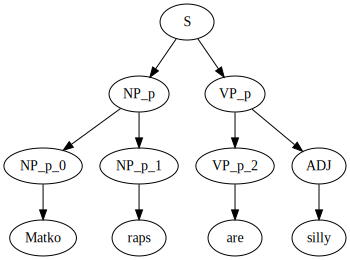

In [590]:
parse_result = trace[-1].derive_trees()[0]
render_tree(parse_result)

We can remove all non-terminals not in the original grammar to get a representation of the parse in terms of that original grammar.

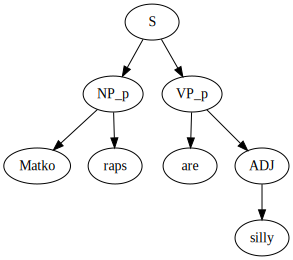

In [591]:
render_tree(parsing.filter_non_terminals(parse_result, cfg.n))

We can observe the individual steps of the CYK algorithm like so:

In [592]:
util.Carousel(trace)

,0: Matko,1: raps,2: are,3: silly
0: Matko,,,,
1: raps,,,,
2: are,,,,
3: silly,,,,
,0: Matko,1: raps,2: are,3: silly
0: Matko,,,,
1: raps,,,,
2: are,,,,
3: silly,,,,
,0: Matko,1: raps,2: are,3: silly


## Ambiguity 
For real world grammars many phrases have several legal parse trees. Which one is the correct one depends on the intent of the speaker. That said, in many cases it is quite obvious that one parse tree should be more likely, or have a higher _probability_. This suggest a probabilistic treatment of grammars and parsing. Before we introduce probabilistic CFGs, let us inspect a typical case of syntactic natural language ambiguity.

Consider the following grammar and sentence.

In [593]:
amb_cfg = CFG.from_rules([
        ('S',    ['Subj','VP']),
        ('Subj', ['He']),
        ('Verb', ['shot']),
        ('VP',   ['Verb', 'Obj']),        ('VP', ['Verb', 'Obj', 'PP']),
        ('PP',   ['in','his','pyjamas']),
        ('Obj',  ['the','elephant']),     ('Obj', ['the','elephant','PP'])
    ])
amb_cnf_cfg = to_cnf(amb_cfg)
amb_sentence = ["He", "shot", "the", "elephant", "in", "his", "pyjamas"]

We can parse this sentence as before, using the CYK algorithm. This time there will be two parses though:

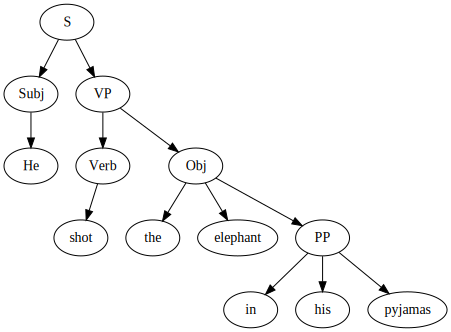

In [594]:
amb_trace = cyk(amb_cnf_cfg, amb_sentence)
amb_parse_results = amb_trace[-1].derive_trees()
render_tree(parsing.filter_non_terminals(amb_parse_results[0],amb_cfg.n))

The second parse is:

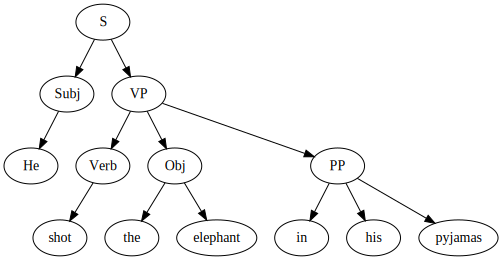

In [595]:
render_tree(parsing.filter_non_terminals(amb_parse_results[1],amb_cfg.n))

The example is an instance of _prepositional phrase attachment ambiguity_: the "in his pyjamas" phrase could both be part of the verb phrase, meaning that the shooting happened in pyjamas, or part of the noun phrase "the elephant", meaning that the elephant was in pyjamas. Both readings make syntactic sense, so there is nothing wrong with the grammar. However, we would like the machine to return the preferred reading when such sentence is parsed. For this we need to find a way to assign different readings different probabilities. <span class="summary">Can we assign the better parse a higher _probability_?</span> 

## Probabilistic Context Free Grammars
[Probabilistic Context Free Grammars](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/pcfgs.pdf) (PFCGs) are Context Free Grammars in which rules have probabilities. More formally, a PCFG consists of 

* A Context Free Grammar \\(G(N,\Sigma,R,S)\\).
* A parameter \\(q(\alpha \rightarrow \beta)\\) for each rule  \\(\alpha \rightarrow \beta \in R\\). For each possible left hand side \\(\alpha \in N\\) we require \\(\sum_\beta q(\alpha \rightarrow \beta) = 1\\).

A PCFG defines a probability distribution over parse trees as follows. Given a parse tree \\(\mathbf{t}\\) that contains the rules \\(\alpha_1 \rightarrow \beta_1, \ldots, \alpha_n \rightarrow \beta_n\\), the probability of this tree under the PCFG is:
$$
  \newcommand{parse}{\mathbf{t}}
  p(\parse) = \prod_i^n q(\alpha_i \rightarrow \beta_i) 
$$

Notice that we can develop and operate parsers with the structured prediction recipe. We have model \\(p\\), some parameters \\(\params\\) that need to be estimated on a training set, and the prediction/search problem of finding the most likely parse tree given a sentence. The next sections will cover these aspects.

Before we show examples, let us define a Python data structure for
PCFGs.    

In [659]:
class PCFG:
    def __init__(self, cfg, probs):
        """
        Create a new PCFG.
        Args:
            cfg: a CFG object.
            probs: a dict from rules to probabilities. 
        """
        self.cfg = cfg
        self.probs = defaultdict(lambda: 1.0)
        self.probs.update(probs)

    def prob(self, rule):
        return self.probs[rule]
    
    def prob_rules(self):
        return ((lhs,self.prob((lhs,rhs)),rhs) for lhs,rhs in self.cfg.r)
    
    @classmethod
    def from_rules(cls, rules, s='S'):
        """
        Creates a PCFG from a list of weighted rules.
        Args:
            rules: a list of rules of shape `(lhs,prob,rhs)` where `lhs` is a non-terminal, `prob` a real number
                `rhs` a list of right-hand side symbols the rule expands to.
            s: start symbol.
        Returns:
            PCFG with rules as specified, with terminals and non-terminals determined by which terminals are on the
                left hand side of the rules.
        """
        non_terminals = {lhs for lhs,_,_ in rules}
        left_hand_sides = {node 
                           for _,_,rhs in rules 
                           for node in rhs}
        terminals = {n for n in left_hand_sides if n not in non_terminals} 
        det_rules = [(lhs,rhs) for lhs,_,rhs in rules]
        cfg = CFG(non_terminals, terminals, det_rules, s)
        probs = [((lhs,tuple(rhs)),prob) for lhs,prob,rhs in rules]
        return cls(cfg,probs)
    
    def _repr_html_(self):
        """
        Simple HTML representation of a PCFG for easy rendering in notebook.
        Returns:
            an HTML string representing the PCFG as table.
        """
        rules = ["<tr><td>{}</td><td>{}</td><td>{}</td></tr>".format(lhs,self.prob((lhs,rhs)), " ".join(rhs)) 
                 for lhs, rhs in self.cfg.r]
        return "<table>{}</table>".format("".join(rules))                                     

Let's create a probabilistic version of the ambiguous CFG shown above.

In [683]:
pcfg = PCFG.from_rules([
        ('S',    1.0, ['Subj','VP']),
        ('Subj', 1.0, ['He']),
        ('Verb', 1.0, ['shot']),
        ('VP',   0.3, ['Verb', 'Obj']),        ('VP',  0.7, ['Verb', 'Obj', 'PP']),
        ('PP',   1.0, ['in','his','pyjamas']),
        ('Obj',  0.5, ['the','elephant']),     ('Obj', 0.5, ['the','elephant','PP'])
    ])
pcfg

S,1.0,Subj VP
Subj,1.0,He
Verb,1.0,shot
VP,0.3,Verb Obj
VP,0.7,Verb Obj PP
PP,1.0,in his pyjamas
Obj,0.5,the elephant
Obj,0.5,the elephant PP


Let us first focus on the prediction task: given a sentence, find the highest scoring parse tree. In a way, we have already solved a variant of this problem. We can consider a CFG as a deterministic distribution over trees, and finding _a_ highest scoring parse is equivalent to finding any legal tree&mdash;our bottom-up and dynamic program based algorithms hence performed a structured prediction.

### CYK for PCFGs
Here we present a probabilistic variant of the CYK algorithm. First we convert the PCFG to CNF form.

In [684]:
def to_pcnf(pcfg):
    # go through all rules, check if rule 1) or 2) can be applied, create new rules
    new_non_terminals = []

    def fresh_non_terminal(prefix):
        new_non_terminal = prefix + "_" + str(len(new_non_terminals))
        new_non_terminals.append(new_non_terminal)
        return new_non_terminal

    def transform_rule(rule):
        lhs, prob, rhs = rule
        if len(rhs) > 2:
            # lhs -> r1 r2 ... rn
            new_lhs = fresh_non_terminal(lhs)
            new_rule_1 = (lhs, prob, rhs[:1] + (new_lhs,))
            new_rule_2 = (new_lhs, 1.0, rhs[1:])
            return transform_rule(new_rule_1) + transform_rule(new_rule_2)
        elif len(rhs) == 2 and any((n in pcfg.cfg.sigma for n in rhs)):
            new_rules = []
            new_rhs = []
            for n in rhs:
                if n in pcfg.cfg.sigma:
                    new_lhs = fresh_non_terminal(lhs)
                    new_rule = (new_lhs, 1.0, [n])
                    new_rules.append(new_rule)
                    new_rhs.append(new_lhs)
                else:
                    new_rhs.append(n)
            new_rules.append((lhs, prob, new_rhs))
            return sum([transform_rule(r) for r in new_rules], [])
        else:
            return [(lhs,prob,rhs)]

    result = []
    for rule in pcfg.prob_rules():
        result += transform_rule(rule)

    return PCFG.from_rules(result)
    
cnf_pcfg = to_pcnf(pcfg)
cnf_pcfg
# pcfg.cfg.r

S,1.0,Subj VP
Subj,1.0,He
Verb,1.0,shot
VP,0.3,Verb Obj
VP,0.7,Verb VP_0
VP_0,1.0,Obj PP
PP_2,1.0,in
PP,1.0,PP_2 PP_1
PP_1_3,1.0,his
PP_1_4,1.0,pyjamas
PP_1,1.0,PP_1_3 PP_1_4


TODO: The probabilistic version of the CYK algorithm proceeds almost exactly as the non-probabilistic version. Now we maintain for each span $(i,j)$ and each non-terminal label $l$ a (log) score. This score is equal to the highest score of any tree that spans $(i,j)$ and has the top label $l$. Notice that for $(i,j)$ and $l$ we only remember the pair of child cells and labels that produced the highest score, not all.

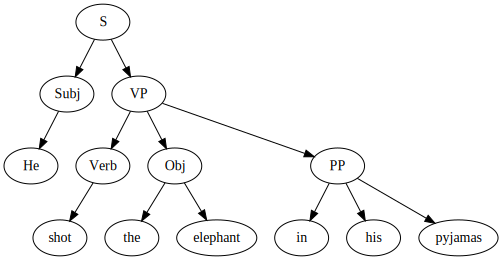

In [686]:
import math

def pcyk(pcfg, s):
    """
    Performs the CYK algorithm on sentence `s` given a probabilistic CFG `pcfg`.
    Args:
        cfg: a PCFG in CNF.
        s: a sentence as a list of tokens (strings).
    """
    chart = parsing.Chart(s)
    trace = [copy.deepcopy(chart)]
    n = len(s)
    for i in range(0,n):
        chart.clear_cell_marks()
        chart.mark_target(i,i)
        trace.append(copy.deepcopy(chart))
        for lhs,rhs in [(lhs,rhs) for lhs, rhs in pcfg.cfg.r if rhs == (s[i],)]:
            chart.update_label(i,i,lhs, math.log(pcfg.prob((lhs,rhs))))
            chart.mark_cyk_terminal(i, lhs)
            trace.append(copy.deepcopy(chart))
    for width in range(1,n):
        for begin in range(0, n-width):
            end = begin + width
            for middle in range(begin, end):
                chart.mark_cyk_focus(begin, middle, end)
                trace.append(copy.deepcopy(chart)) 
                for beta in chart.labels_at_cell(begin, middle):
                    for gamma in chart.labels_at_cell(middle+1, end):
                        chart.mark_cyk_source_focus(begin, middle, end, beta, gamma)
                        trace.append(copy.deepcopy(chart))
                        labels = [lhs for lhs, rhs in pcfg.cfg.r if rhs == (beta, gamma)]
                        for alpha in labels:
                            prob = pcfg.prob((alpha,(beta,gamma)))
                            new_score = math.log(prob) + chart.score(begin,middle,beta) + chart.score(middle+1,end,gamma)
                            old_score = chart.score(begin,end,alpha)
                            if new_score > old_score:
                                chart.update_label(begin, end, alpha, new_score, [(begin,middle,beta),(middle+1,end,gamma)])
                                chart.mark_cyk_rule(begin, end, alpha)
                                trace.append(copy.deepcopy(chart))
    chart.clear_marks()
    trace.append(chart)
    return trace

pcyk_trace = pcyk(cnf_pcfg, amb_sentence)
render_tree(parsing.filter_non_terminals(pcyk_trace[-1].derive_trees()[0],pcfg.cfg.n))